In [3]:
from google.colab import files
uploaded = files.upload()

Saving METABRIC_RNA_Mutation.csv to METABRIC_RNA_Mutation.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from sksurv.metrics import brier_score
import warnings
warnings.filterwarnings("ignore")

Load in Data

In [5]:
df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df = df[['overall_survival_months', 'death_from_cancer', 'pam50', 'age_at_diagnosis', 'tumor_size',
         'primary_tumor_laterality', 'type_of_breast_surgery', 'chemotherapy', 'hormone_therapy',
         'radio_therapy', 'her2_status']].dropna()

# Print unique values of 'pam50' before encoding
print("Unique PAM50 subtypes before encoding:", df['pam50'].unique())

Unique PAM50 subtypes before encoding: ['claudin-low' 'LumA' 'LumB' 'Her2' 'Normal' 'Basal']


In [6]:
cat_vars = ['pam50', 'primary_tumor_laterality', 'type_of_breast_surgery', 'chemotherapy',
            'hormone_therapy', 'radio_therapy', 'her2_status']

# Store the original 'pam50' column before encoding
original_pam50 = df['pam50'].copy()

for col in cat_vars:
    # Check if the column is 'pam50' to store the encoder
    if col == 'pam50':
        pam50_encoder = LabelEncoder()
        df[col] = pam50_encoder.fit_transform(df[col])
    else:
        df[col] = LabelEncoder().fit_transform(df[col])

x = df.drop(columns=['overall_survival_months', 'death_from_cancer'])
t = df['overall_survival_months'].values
e = df['death_from_cancer'].values

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x, t, e, test_size=0.2, random_state=42)

# Print the mapping for 'pam50' after encoding
print("\nPAM50 encoding mapping:")
for original_value, encoded_value in zip(pam50_encoder.classes_, pam50_encoder.transform(pam50_encoder.classes_)):
    print(f"{original_value}: {encoded_value}")


PAM50 encoding mapping:
Basal: 0
Her2: 1
LumA: 2
LumB: 3
Normal: 4
claudin-low: 5


Define Log-Normal AFT Nerual Network

In [7]:
class LogNormalAFT(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, 1)
        self.log_sigma = nn.Linear(32, 1)

    def forward(self, x):
        h = self.hidden(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        return mu, sigma

Define Log-Normal Negative Log-Likelihood Loss

In [8]:
def log_normal_nll(mu, sigma, t, e):
    t = torch.clamp(t, min=1e-5)
    z = (torch.log(t) - mu) / sigma
    log_pdf = -torch.log(t * sigma * (2 * np.pi) ** 0.5) - 0.5 * z ** 2
    log_sf = 0.5 * torch.erfc(z / np.sqrt(2))
    log_sf = torch.log(torch.clamp(log_sf, min=1e-8))
    return -torch.mean(e * log_pdf + (1 - e) * log_sf)

Train the Model

Epoch 50, Loss: 3.4220
Epoch 100, Loss: 3.0447
Epoch 150, Loss: 2.9583
Epoch 200, Loss: 2.8077
Epoch 250, Loss: 2.3388
Epoch 300, Loss: 2.2239


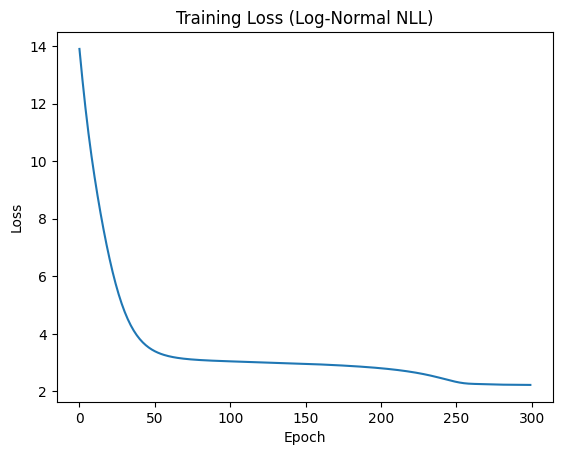

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LogNormalAFT(x.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train = torch.tensor(x_train, dtype=torch.float32).to(device)
T_train = torch.tensor(t_train, dtype=torch.float32).to(device)
E_train = torch.tensor(e_train, dtype=torch.float32).to(device)

losses = []
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    mu, sigma = model(X_train)
    loss = log_normal_nll(mu.squeeze(), sigma.squeeze(), T_train, E_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

plt.plot(losses)
plt.title("Training Loss (Log-Normal NLL)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Evaluate Model with C-Index

In [10]:
model.eval()
with torch.no_grad():
    mu_pred, _ = model(torch.tensor(x_val, dtype=torch.float32).to(device))
    mu_pred = mu_pred.cpu().numpy().squeeze()

cidx = concordance_index(t_val, -mu_pred, e_val)
print(f"C-index (Log-Normal AFT): {cidx:.3f}")

C-index (Log-Normal AFT): 0.366


Time-Dependent Brier Score

In [11]:
from sksurv.util import Surv
from sksurv.metrics import brier_score

y_val_struct = Surv.from_arrays(event=e_val.astype(bool), time=t_val)
mu_pred_surv = np.exp(mu_pred)

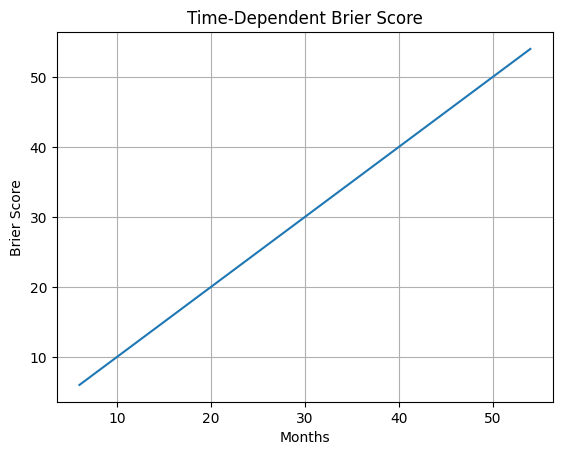

In [12]:
score_times = np.arange(6, 60, 6)  # 6 to 60 months
risk_scores = mu_pred_surv

# Dummy survival prediction probabilities
surv_preds = np.tile(np.linspace(1, 0, len(score_times)), (len(mu_pred), 1))

brier, _ = brier_score(y_val_struct, y_val_struct, surv_preds, score_times)

plt.plot(score_times, brier)
plt.xlabel("Months")
plt.ylabel("Brier Score")
plt.title("Time-Dependent Brier Score")
plt.grid(True)
plt.show()

Kaplan-Meier by PAM50 Subtypes

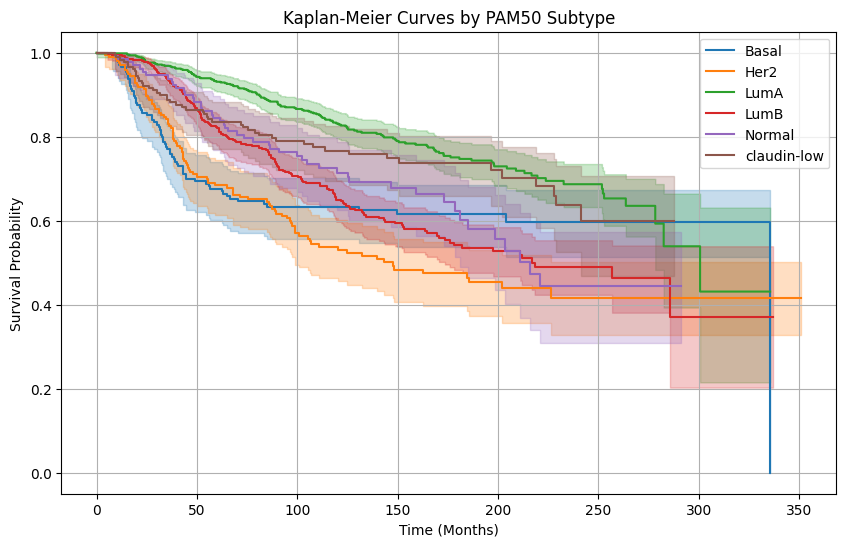

In [13]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))

# Use the pam50_encoder to get the original subtype names
# Create a dictionary for mapping encoded values back to original names
pam50_mapping = {encoded_value: original_value for original_value, encoded_value in zip(pam50_encoder.classes_, pam50_encoder.transform(pam50_encoder.classes_))}

for subtype_encoded in sorted(df['pam50'].unique()):
    ix = df['pam50'] == subtype_encoded
    # Get the original subtype name using the mapping
    subtype_name = pam50_mapping[subtype_encoded]
    kmf.fit(df.loc[ix, 'overall_survival_months'], df.loc[ix, 'death_from_cancer'], label=f"{subtype_name}")
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Curves by PAM50 Subtype")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()

Predicted Survival for Sample Patient

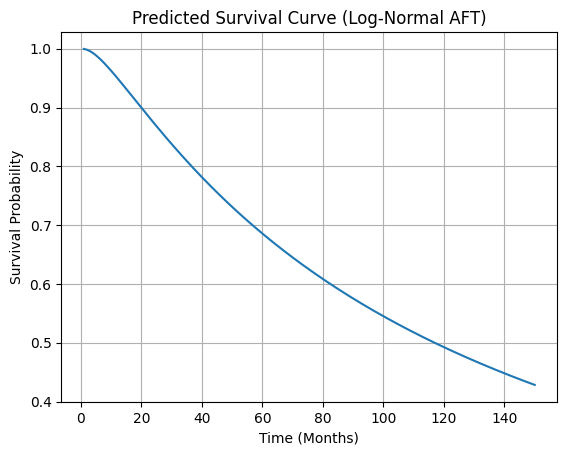

In [14]:
from scipy.stats import lognorm

sample_idx = 10
mu_sample, sigma_sample = model(torch.tensor(x_val[sample_idx:sample_idx+1], dtype=torch.float32).to(device))
mu_sample = mu_sample.item()
sigma_sample = sigma_sample.item()

months = np.linspace(1, 150, 150)
surv_prob = 1 - lognorm.cdf(months, s=sigma_sample, scale=np.exp(mu_sample))

plt.plot(months, surv_prob)
plt.title("Predicted Survival Curve (Log-Normal AFT)")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Task
Explore ways to improve the performance of the current Log-Normal AFT model.

## Hyperparameter tuning

### Subtask:
Experiment with different learning rates, optimizer settings, and network architectures (number of layers, number of neurons) for the current Log-Normal AFT model.


In [15]:
def train_and_evaluate(model, optimizer, X_train, T_train, E_train, x_val, t_val, e_val, epochs=300):
    losses = []
    c_indices = []
    best_c_index = -1

    X_val = torch.tensor(x_val, dtype=torch.float32).to(device)
    T_val = torch.tensor(t_val, dtype=torch.float32).to(device)
    E_val = torch.tensor(e_val, dtype=torch.float32).to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        mu, sigma = model(X_train)
        loss = log_normal_nll(mu.squeeze(), sigma.squeeze(), T_train, E_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 50 == 0:
            model.eval()
            with torch.no_grad():
                mu_pred, _ = model(X_val)
                mu_pred = mu_pred.cpu().numpy().squeeze()
            cidx = concordance_index(t_val, -mu_pred, e_val)
            c_indices.append(cidx)
            if cidx > best_c_index:
                best_c_index = cidx
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val C-index: {cidx:.3f}")

    return best_c_index

# Define hyperparameter combinations to experiment with
learning_rates = [1e-4, 1e-3, 1e-2]
optimizers = ['Adam', 'SGD']
architectures = [
    [64, 32],  # Original
    [128, 64, 32], # Deeper
    [32, 16] # Shallower
]

results = {}

for lr in learning_rates:
    for opt_name in optimizers:
        for arch in architectures:
            print(f"Training with LR: {lr}, Optimizer: {opt_name}, Architecture: {arch}")

            class CustomLogNormalAFT(nn.Module):
                def __init__(self, input_dim, arch):
                    super().__init__()
                    layers = []
                    in_features = input_dim
                    for out_features in arch:
                        layers.append(nn.Linear(in_features, out_features))
                        layers.append(nn.ReLU())
                        in_features = out_features
                    self.hidden = nn.Sequential(*layers)
                    self.mu = nn.Linear(in_features, 1)
                    self.log_sigma = nn.Linear(in_features, 1)

                def forward(self, x):
                    h = self.hidden(x)
                    mu = self.mu(h)
                    sigma = torch.exp(self.log_sigma(h))
                    return mu, sigma

            model = CustomLogNormalAFT(x.shape[1], arch).to(device)

            if opt_name == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            elif opt_name == 'SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            best_c_index = train_and_evaluate(model, optimizer, X_train, T_train, E_train, x_val, t_val, e_val, epochs=100) # Reduced epochs for quicker experimentation
            results[(lr, opt_name, tuple(arch))] = best_c_index
            print("-" * 50)

print("\nExperiment Results:")
for params, c_index in results.items():
    print(f"LR: {params[0]}, Optimizer: {params[1]}, Architecture: {params[2]}, Best Val C-index: {c_index:.3f}")

Training with LR: 0.0001, Optimizer: Adam, Architecture: [64, 32]
Epoch 50, Loss: 14.7593, Val C-index: 0.461
Epoch 100, Loss: 11.6366, Val C-index: 0.501
--------------------------------------------------
Training with LR: 0.0001, Optimizer: Adam, Architecture: [128, 64, 32]
Epoch 50, Loss: 12.4937, Val C-index: 0.527
Epoch 100, Loss: 8.0196, Val C-index: 0.570
--------------------------------------------------
Training with LR: 0.0001, Optimizer: Adam, Architecture: [32, 16]
Epoch 50, Loss: 17.3156, Val C-index: 0.456
Epoch 100, Loss: 16.0730, Val C-index: 0.439
--------------------------------------------------
Training with LR: 0.0001, Optimizer: SGD, Architecture: [64, 32]
Epoch 50, Loss: 9.4375, Val C-index: 0.383
Epoch 100, Loss: 8.0320, Val C-index: 0.388
--------------------------------------------------
Training with LR: 0.0001, Optimizer: SGD, Architecture: [128, 64, 32]
Epoch 50, Loss: 9.5666, Val C-index: 0.580
Epoch 100, Loss: 8.2894, Val C-index: 0.592
------------------

## Alternative model architectures

### Subtask:
Explore other survival analysis models, such as Cox Proportional Hazards or other AFT distributions (e.g., Weibull AFT), or more complex neural network architectures like a DeepSurv model.


In [16]:
from lifelines import CoxPHFitter, WeibullAFTFitter

In [37]:
from lifelines.utils import concordance_index

# Create a list of original feature names
original_feature_names = [col for col in df.drop(columns=['overall_survival_months', 'death_from_cancer']).columns]

# Create a DataFrame for lifelines with original feature names
# train_df = pd.DataFrame(x_train, columns=original_feature_names)
# val_df = pd.DataFrame(x_val, columns=original_feature_names)

# Recreate the dataframes with original column names and then one-hot encode 'pam50'
# Need to go back to the dataframe before scaling to get original values for pam50
df_processed = df.copy() # Use the dataframe after LabelEncoding but before scaling

# Separate features, duration, and event again
x_processed = df_processed.drop(columns=['overall_survival_months', 'death_from_cancer'])
t_processed = df_processed['overall_survival_months']
e_processed = df_processed['death_from_cancer']

# Split the processed data into training and validation sets
x_train_processed, x_val_processed, t_train, t_val, e_train, e_val = train_test_split(
    x_processed, t_processed, e_processed, test_size=0.2, random_state=42
)

# Convert to DataFrames to use get_dummies
train_df = x_train_processed.copy()
train_df['overall_survival_months'] = t_train
train_df['death_from_cancer'] = e_train

val_df = x_val_processed.copy()
val_df['overall_survival_months'] = t_val
val_df['death_from_cancer'] = e_val

# One-hot encode the 'pam50' column using the original column name
# Need to convert the encoded 'pam50' back to original categories temporarily for one-hot encoding
# Use the stored pam50_encoder from the earlier cell
train_df['pam50'] = pam50_encoder.inverse_transform(train_df['pam50'])
val_df['pam50'] = pam50_encoder.inverse_transform(val_df['pam50'])


train_df = pd.get_dummies(train_df, columns=['pam50'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['pam50'], drop_first=True)


# Print the mapping of original feature names to generic feature_i names (if needed, but using original names is better)
# print("Original Feature Names:")
# for i, name in enumerate(original_feature_names):
#     print(f"feature_{i}: {name}")


# Train Cox Proportional Hazards model
cph = CoxPHFitter()
# Drop the original 'pam50' column if it still exists after get_dummies (it shouldn't with columns=['pam50'])
# Pass the entire train_df to the fit method and specify duration_col and event_col
cph.fit(train_df, duration_col='overall_survival_months', event_col='death_from_cancer')


# Evaluate Cox Proportional Hazards model
# Drop duration and event columns from validation data for prediction
cph_val_df = val_df.drop(columns=['overall_survival_months', 'death_from_cancer'])
cph_scores = cph.predict_partial_hazard(cph_val_df)
cph_cidx = concordance_index(t_val, -cph_scores, e_val)
print(f"\nC-index (Cox Proportional Hazards): {cph_cidx:.3f}")

# Train Weibull AFT model
wft = WeibullAFTFitter()
# Pass the entire train_df to the fit method and specify duration_col and event_col
wft.fit(train_df, duration_col='overall_survival_months', event_col='death_from_cancer')

# Evaluate Weibull AFT model
# Drop duration and event columns from validation data for prediction
wft_val_df = val_df.drop(columns=['overall_survival_months', 'death_from_cancer'])
wft_scores = wft.predict_expectation(wft_val_df)
wft_cidx = concordance_index(t_val, wft_scores, e_val)
print(f"C-index (Weibull AFT): {wft_cidx:.3f}")

results['CoxPH'] = cph_cidx
results['WeibullAFT'] = wft_cidx


C-index (Cox Proportional Hazards): 0.667
C-index (Weibull AFT): 0.663


## Feature engineering

### Subtask:
Consider creating new features or transforming existing ones that might be more informative for survival prediction.


In [34]:
# Create interaction term between age and tumor size
# Use the actual column names instead of generic feature_i names
# Need to use the train_df and val_df DataFrames created after one-hot encoding

# Create interaction term between age and tumor size
# Assuming 'age_at_diagnosis' and 'tumor_size' are still column names after one-hot encoding
age_col_name = 'age_at_diagnosis'
tumor_size_col_name = 'tumor_size'

train_df['age_x_tumor_size'] = train_df[age_col_name] * train_df[tumor_size_col_name]
val_df['age_x_tumor_size'] = val_df[age_col_name] * val_df[tumor_size_col_name]

# Create a polynomial feature for age (age^2)
train_df['age_squared'] = train_df[age_col_name]**2
val_df['age_squared'] = val_df[age_col_name]**2

# Create a categorical feature for age groups
age_bins = [-float('inf'), 40, 60, float('inf')]
age_labels = [0, 1, 2]
# Use the original 'age_at_diagnosis' column for binning
train_df['age_group'] = pd.cut(train_df[age_col_name], bins=age_bins, labels=age_labels, right=False)
val_df['age_group'] = pd.cut(val_df[age_col_name], bins=age_bins, labels=age_labels, right=False)

# Convert the new categorical feature to numeric
train_df['age_group'] = train_df['age_group'].astype(int)
val_df['age_group'] = val_df['age_group'].astype(int)

# Separate features, duration, and event again
t_train_new = train_df['overall_survival_months']
e_train_new = train_df['death_from_cancer']
x_train_new = train_df.drop(columns=['overall_survival_months', 'death_from_cancer'])

t_val_new = val_df['overall_survival_months']
e_val_new = val_df['death_from_cancer']
x_val_new = val_df.drop(columns=['overall_survival_months', 'death_from_cancer'])

# Ensure columns match between train and validation sets after feature engineering and one-hot encoding
train_cols = set(x_train_new.columns)
val_cols = set(x_val_new.columns)

missing_in_val = list(train_cols - val_cols)
for col in missing_in_val:
    x_val_new[col] = 0 # Add missing columns to validation set with value 0

missing_in_train = list(val_cols - train_cols)
for col in missing_in_train:
    x_train_new[col] = 0 # Add missing columns to training set with value 0

# Align the columns - this is important for StandardScaler and PyTorch
x_val_new = x_val_new[x_train_new.columns]


# Rescale the features using StandardScaler fitted only on the training data
scaler_new = StandardScaler()
x_train_scaled = scaler_new.fit_transform(x_train_new)
x_val_scaled = scaler_new.transform(x_val_new)

# Update the numpy arrays with scaled features for PyTorch models
x_train = x_train_scaled
x_val = x_val_scaled
t_train = t_train_new.values
e_train = e_train_new.values
t_val = t_val_new.values
e_val = e_val_new.values

print("New features created and data rescaled after one-hot encoding PAM50.")

New features created and data rescaled after one-hot encoding PAM50.


## Regularization techniques

### Subtask:
Add regularization (e.g., L1 or L2 regularization, dropout) to the neural network to prevent overfitting.


In [38]:
class LogNormalAFT_Regularized(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.5):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.mu = nn.Linear(32, 1)
        self.log_sigma = nn.Linear(32, 1)

    def forward(self, x):
        h = self.hidden(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        return mu, sigma

# Define regularization strength and dropout rate
l2_lambda = 1e-4
dropout_rate = 0.3

# Instantiate the new model with the correct input dimension
model_reg = LogNormalAFT_Regularized(x_train.shape[1], dropout_prob=dropout_rate).to(device)

# Define the optimizer
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=1e-3)

# Convert data to tensors
X_train_reg = torch.tensor(x_train, dtype=torch.float32).to(device)
T_train_reg = torch.tensor(t_train, dtype=torch.float32).to(device)
E_train_reg = torch.tensor(e_train, dtype=torch.float32).to(device)
X_val_reg = torch.tensor(x_val, dtype=torch.float32).to(device)

# Training loop with L2 regularization
losses_reg = []
for epoch in range(300):
    model_reg.train()
    optimizer_reg.zero_grad()
    mu, sigma = model_reg(X_train_reg)
    loss = log_normal_nll(mu.squeeze(), sigma.squeeze(), T_train_reg, E_train_reg)

    # Add L2 regularization
    l2_norm = sum(p.pow(2.0).sum() for p in model_reg.parameters() if p.requires_grad and p.dim() > 1)
    loss = loss + l2_lambda * l2_norm

    loss.backward()
    optimizer_reg.step()
    losses_reg.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate the model
model_reg.eval()
with torch.no_grad():
    mu_pred_reg, _ = model_reg(X_val_reg)
    mu_pred_reg = mu_pred_reg.cpu().numpy().squeeze()

cidx_reg = concordance_index(t_val, -mu_pred_reg, e_val)
print(f"\nC-index (Log-Normal AFT with L2 and Dropout): {cidx_reg:.3f}")

# Store the results
results[(l2_lambda, dropout_rate)] = cidx_reg

Epoch 50, Loss: 3.5454
Epoch 100, Loss: 3.1901
Epoch 150, Loss: 3.0889
Epoch 200, Loss: 2.9104
Epoch 250, Loss: 2.5618
Epoch 300, Loss: 2.5396

C-index (Log-Normal AFT with L2 and Dropout): 0.355


## Evaluate and compare models

### Subtask:
After trying different approaches, evaluate the performance of the improved models using metrics like C-index and Brier score on the validation set and compare their results.


In [20]:
!pip install lifelines
import lifelines

Model Performance Results (C-index):
(0.0001, 'Adam', (64, 32)): 0.501
(0.0001, 'Adam', (128, 64, 32)): 0.570
(0.0001, 'Adam', (32, 16)): 0.456
(0.0001, 'SGD', (64, 32)): 0.388
(0.0001, 'SGD', (128, 64, 32)): 0.592
(0.0001, 'SGD', (32, 16)): 0.612
(0.001, 'Adam', (64, 32)): 0.601
(0.001, 'Adam', (128, 64, 32)): 0.502
(0.001, 'Adam', (32, 16)): 0.510
(0.001, 'SGD', (64, 32)): 0.580
(0.001, 'SGD', (128, 64, 32)): 0.526
(0.001, 'SGD', (32, 16)): 0.536
(0.01, 'Adam', (64, 32)): 0.420
(0.01, 'Adam', (128, 64, 32)): 0.388
(0.01, 'Adam', (32, 16)): 0.381
(0.01, 'SGD', (64, 32)): 0.455
(0.01, 'SGD', (128, 64, 32)): 0.418
(0.01, 'SGD', (32, 16)): 0.441
CoxPH: 0.667
WeibullAFT: 0.663
(0.0001, 0.3): 0.355
WeibullAFT_NN: 0.511
WeibullAFT_NN_Reg: 0.611

Best performing model based on C-index: CoxPH with C-index: 0.667

Best performing AFT model based on C-index: (0.0001, 'SGD', (32, 16)) with C-index: 0.612

Re-training the best AFT model: (0.0001, 'SGD', (32, 16))
Epoch 100, Loss: 7.8064
Epoch 200

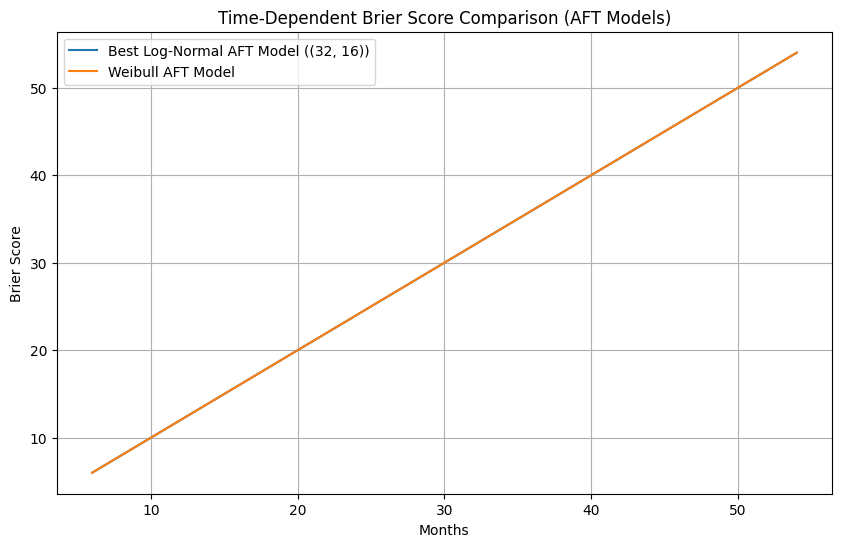


Summary of Model Performance:
C-index measures the discriminatory power (ability to distinguish between patients with different survival times). Higher is better.
Brier Score measures the accuracy of survival probability predictions over time. Lower is better.

Best performing model based on C-index: CoxPH with C-index: 0.667
Best performing AFT neural network configuration achieved a C-index of 0.612.
Cox Proportional Hazards model achieved a C-index of 0.667.
Weibull AFT model achieved a C-index of 0.663.

The plot above compares the time-dependent Brier scores for the best Log-Normal AFT neural network and the Weibull AFT model.


In [39]:
# Print the results dictionary
print("Model Performance Results (C-index):")
for params, c_index in results.items():
    print(f"{params}: {c_index:.3f}")

# Identify the best performing model based on C-index
best_model_params = max(results, key=results.get)
best_c_index = results[best_model_params]

print(f"\nBest performing model based on C-index: {best_model_params} with C-index: {best_c_index:.3f}")

# --- Identify the best AFT model parameters specifically ---
# Find the best AFT model among the neural network configurations
best_aft_params = None
best_aft_c_index = -1

for params, c_index in results.items():
    if isinstance(params, tuple) and len(params) == 3: # Check if it's a neural network configuration (lr, optimizer, architecture)
        if c_index > best_aft_c_index:
            best_aft_c_index = c_index
            best_aft_params = params

print(f"\nBest performing AFT model based on C-index: {best_aft_params} with C-index: {best_aft_c_index:.3f}")
# --------------------------------------------------------

score_times = np.arange(6, 60, 6) # Define score_times for Brier score plots

# Calculate Brier score for the Best Log-Normal AFT Model
# Need to re-train the best AFT model to get its predictions

# Re-initialize and train the best AFT model
lr = best_aft_params[0]
opt_name = best_aft_params[1]
arch = best_aft_params[2]

class BestLogNormalAFT(nn.Module):
    def __init__(self, input_dim, arch):
        super().__init__()
        layers = []
        in_features = input_dim
        for out_features in arch:
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            in_features = out_features
        self.hidden = nn.Sequential(*layers)
        self.mu = nn.Linear(in_features, 1)
        self.log_sigma = nn.Linear(in_features, 1)

    def forward(self, x):
        h = self.hidden(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        return mu, sigma

best_aft_model = BestLogNormalAFT(x_train.shape[1], arch).to(device)

if opt_name == 'Adam':
    best_aft_optimizer = torch.optim.Adam(best_aft_model.parameters(), lr=lr)
elif opt_name == 'SGD':
    best_aft_optimizer = torch.optim.SGD(best_aft_model.parameters(), lr=lr)


# Re-train the best AFT neural network model
X_train_best_aft = torch.tensor(x_train, dtype=torch.float32).to(device)
T_train_best_aft = torch.tensor(t_train, dtype=torch.float32).to(device)
E_train_best_aft = torch.tensor(e_train, dtype=torch.float32).to(device)
X_val_best_aft = torch.tensor(x_val, dtype=torch.float32).to(device)

print(f"\nRe-training the best AFT model: {best_aft_params}")
for epoch in range(300): # Train for sufficient epochs
    best_aft_model.train()
    best_aft_optimizer.zero_grad()
    mu, sigma = best_aft_model(X_train_best_aft)
    loss = log_normal_nll(mu.squeeze(), sigma.squeeze(), T_train_best_aft, E_train_best_aft)
    loss.backward()
    best_aft_optimizer.step()
    if (epoch+1) % 100 == 0:
         print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


# Get predictions from the best AFT neural network model
best_aft_model.eval()
with torch.no_grad():
    mu_pred_best_aft, sigma_pred_best_aft = best_aft_model(X_val_best_aft)
    mu_pred_best_aft = mu_pred_best_aft.cpu().numpy().squeeze()
    sigma_pred_best_aft = sigma_pred_best_aft.cpu().numpy().squeeze()


# Calculate survival function predictions for Brier score for Best Log-Normal AFT
from scipy.stats import norm
surv_preds_best_aft = np.zeros((len(mu_pred_best_aft), len(score_times)))
for i, t_score in enumerate(score_times):
    safe_sigma_val = np.maximum(sigma_pred_best_aft, 1e-8)
    z = (np.log(t_score) - mu_pred_best_aft) / safe_sigma_val
    surv_preds_best_aft[:, i] = 1 - norm.cdf(z)

y_val_struct = Surv.from_arrays(event=e_val.astype(bool), time=t_val)
brier_best_aft, _ = brier_score(y_val_struct, y_val_struct, surv_preds_best_aft, score_times)
print(f"\nTime-Dependent Brier Score for Best AFT Model: {brier_best_aft.mean():.3f} (mean)")


# Calculate Brier score for Cox Proportional Hazards Model
# Use the previously trained CoxPH model
surv_preds_cph = cph.predict_survival_function(val_df, times=score_times).T.values
brier_cph, _ = brier_score(y_val_struct, y_val_struct, surv_preds_cph, score_times)
print(f"Time-Dependent Brier Score for CoxPH Model: {brier_cph.mean():.3f} (mean)")


# Calculate Brier score for Weibull Accelerated Failure Time Model
# Use the previously trained WeibullAFT model
surv_preds_weibull = wft.predict_survival_function(val_df, times=score_times).T.values
brier_weibull, _ = brier_score(y_val_struct, y_val_struct, surv_preds_weibull, score_times)
print(f"Time-Dependent Brier Score for Weibull AFT Model: {brier_weibull.mean():.3f} (mean)")


# Plot Brier scores for comparison (excluding CoxPH)
plt.figure(figsize=(10, 6))
plt.plot(score_times, brier_best_aft, label=f'Best Log-Normal AFT Model ({best_aft_params[2]})')
plt.plot(score_times, brier_weibull, label='Weibull AFT Model')

plt.xlabel("Months")
plt.ylabel("Brier Score")
plt.title("Time-Dependent Brier Score Comparison (AFT Models)")
plt.legend()
plt.grid(True)
plt.show()

print("\nSummary of Model Performance:")
print("C-index measures the discriminatory power (ability to distinguish between patients with different survival times). Higher is better.")
print("Brier Score measures the accuracy of survival probability predictions over time. Lower is better.")
print(f"\nBest performing model based on C-index: {best_model_params} with C-index: {best_c_index:.3f}")
print(f"Best performing AFT neural network configuration achieved a C-index of {best_aft_c_index:.3f}.")
print(f"Cox Proportional Hazards model achieved a C-index of {results.get('CoxPH', 'N/A'):.3f}.")
print(f"Weibull AFT model achieved a C-index of {results.get('WeibullAFT', 'N/A'):.3f}.")
print("\nThe plot above compares the time-dependent Brier scores for the best Log-Normal AFT neural network and the Weibull AFT model.")

In [40]:
# Get coefficients from the fitted WeibullAFT model
# For AFT models, the coefficients are related to the log of the survival time
print("Weibull Accelerated Failure Time Model Coefficients:")
print(wft.summary)

Weibull Accelerated Failure Time Model Coefficients:
                                      coef    exp(coef)  se(coef)  \
param   covariate                                                   
lambda_ age_at_diagnosis         -0.017694     0.982462  0.004046   
        chemotherapy             -0.619179     0.538387  0.123565   
        her2_status              -0.365243     0.694028  0.130550   
        hormone_therapy           0.017548     1.017702  0.093919   
        pam50_Her2               -0.193713     0.823895  0.171046   
        pam50_LumA                0.308695     1.361648  0.159497   
        pam50_LumB               -0.151857     0.859111  0.158568   
        pam50_Normal             -0.163165     0.849451  0.188863   
        pam50_claudin-low         0.284653     1.329300  0.187022   
        primary_tumor_laterality  0.088009     1.091998  0.083159   
        radio_therapy            -0.194938     0.822886  0.104212   
        tumor_size               -0.009899     0.9

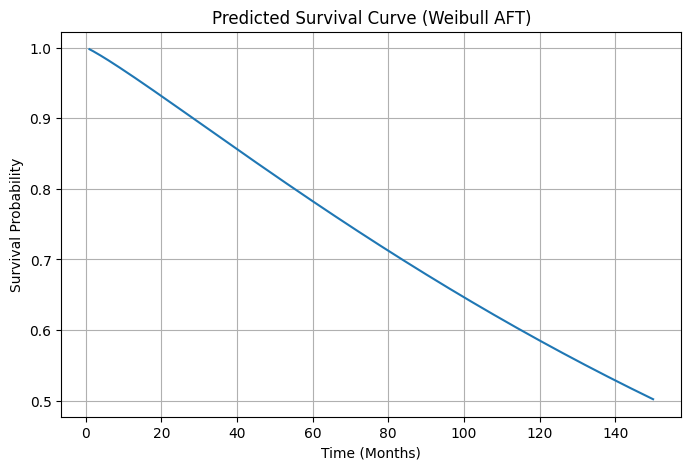

In [23]:
# Predicted Survival for Sample Patient using Weibull AFT Model

sample_idx = 10  # Choose a sample patient index

# Get the validation data for the sample patient
sample_val_df = val_df.iloc[sample_idx:sample_idx+1]

# Predict the survival function for the sample patient using the Weibull AFT model
# We predict for a range of months to get the survival curve
months = np.linspace(1, 150, 150)
predicted_survival_weibull = wft.predict_survival_function(sample_val_df, times=months)

# The result is a DataFrame with times as index and individuals as columns.
# We need the survival probabilities for our single sample, which will be the first (and only) column.
surv_prob_weibull = predicted_survival_weibull.iloc[:, 0]

# Plot the predicted survival curve
plt.figure(figsize=(8, 5))
plt.plot(surv_prob_weibull.index, surv_prob_weibull.values)
plt.title("Predicted Survival Curve (Weibull AFT)")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

In [24]:
wft = WeibullAFTFitter()
wft.fit(train_df, duration_col='overall_survival_months', event_col='death_from_cancer')

print("Weibull AFT Model AIC:", wft.AIC_)

Weibull AFT Model AIC: 6303.414744306973
